In [1]:
import pandas as pd
import numpy as np

In [2]:
bdf = pd.read_excel('bangalore-cas-alerts.xlsx')

In [3]:
bdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207617 entries, 0 to 207616
Data columns (total 7 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   deviceCode_deviceCode               207617 non-null  int64  
 1   deviceCode_location_latitude        207617 non-null  float64
 2   deviceCode_location_longitude       207617 non-null  float64
 3   deviceCode_location_wardName        207617 non-null  object 
 4   deviceCode_pyld_alarmType           207617 non-null  object 
 5   deviceCode_pyld_speed               207617 non-null  int64  
 6   deviceCode_time_recordedTime_$date  207617 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 11.1+ MB


In [4]:
bdf = bdf.rename(columns = {'deviceCode_time_recordedTime_$date':'timestamp'})

In [5]:
bdf['timestamp'] = pd.to_datetime(bdf['timestamp'])
bdf['eventDate'] = pd.to_datetime(bdf['timestamp'])
bdf['eventDate'] = bdf['eventDate'].dt.strftime('%Y%m%d')

In [6]:
bdf['e_hour'] = pd.to_datetime(bdf['timestamp'], format = '%H:%M:%S').dt.hour
bdf['ehourCat'] = 0
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 0) & (bdf['e_hour'] < 6), 1, bdf['ehourCat'])
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 6) & (bdf['e_hour'] < 10), 2, bdf['ehourCat'])
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 10) & (bdf['e_hour'] < 16), 3, bdf['ehourCat'])
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 16) & (bdf['e_hour'] < 21), 4, bdf['ehourCat'])
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 21) & (bdf['e_hour'] < 24), 5, bdf['ehourCat'])

In [7]:
from time import time
from datetime import timedelta
import datetime
from urllib.request import urlopen
import re
from pandas import ExcelWriter

def date_splitter(dateToSplit):
    dateToSplit = dateToSplit.split('-', 1)
    year = dateToSplit[0]
    dateToSplit = dateToSplit[1].split('-', 1)
    month = dateToSplit[0]
    day = dateToSplit[1]
    return year, month, day

def extractTime(s):
    time = re.findall('\d+:\d+', s)
    return time

def extractConditions(s):
    x = re.findall('"small",h:"', s)
    condList = []
    for i in range(len(x)):
        s = s.split('"small",h:"', 1)
        s = s[1].split('."},{s', 1)
        condList.append(s[0])
        s = s[1]
    return condList

def extractVisibility(s):
    s = s.replace('&nbsp;', '')
    re1 = '(\\d+)'
    re2 = ''
    re3 = 'km'
    visibilities = re.findall(re1 + re2 + re3, s)
    return visibilities

def extractTemperature(s):
    s = s.replace('°', '')
    s = s.replace('&nbsp;', '')
    re1='\d+'
    re2='[A-Z]'
    temperatures = re.findall(re1 + re2, s)
    tempList = list()
    for i in range(len(temperatures)):
        x = re.findall(re1, temperatures[i])[0]
        tempList.append(x)
    return tempList

finalRawDf = pd.DataFrame()

# datetime.date.today equals 26th August, 2018. Change accordingly to make the script work for the duration of scraping

for i in range(26, 193):
    startDate = str(datetime.date(2018, 8, 26) + timedelta(days = -i))
    d_year, d_month, d_day = date_splitter(startDate)
    finalDate = d_year + d_month + d_day
    if d_month == '02':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=2&year=2018&json=1'
    elif d_month == '03':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=3&year=2018&json=1'
    elif d_month == '04':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=4&year=2018&json=1'
    elif d_month == '05':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=5&year=2018&json=1'
    elif d_month == '06':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=6&year=2018&json=1'
    elif d_month == '07':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=7&year=2018&json=1'

    #print('Scraping:', link)
    html = urlopen(link)
    s = html.read().decode('utf-8')

    times = extractTime(s)
    visibility = extractVisibility(s)
    temperature = extractTemperature(s)
    condition = extractConditions(s)

    if(len(visibility) < len(condition)):
        remLength = len(condition) - len(visibility)
        for i in range(remLength):
            visibility.append(visibility[0])
    try:
        
        tempDf = pd.DataFrame({
                'weatherDate': finalDate,
                'time': times,
                'temperature': temperature,
                'visibility': visibility,
                'condition': condition
                })

        finalRawDf = finalRawDf.append(tempDf)
    except:
        pass
print('Finished scraping weather data!')
writer = ExcelWriter('bangalore-wheather.xlsx')
finalRawDf.to_excel(writer, index = False, sheet_name = 'Sheet1')
writer.save()

C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Tem

C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Tem

C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Tem

C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Tem

C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\3105654431.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalRawDf = finalRawDf.append(tempDf)
C:\Users\sidby\AppData\Local\Tem

Finished scraping weather data!


In [8]:
bwdf = pd.read_excel('bangalore-weather.xlsx')

In [9]:
bwdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4636 entries, 0 to 4635
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   weatherDate  4636 non-null   int64 
 1   time         4636 non-null   object
 2   temperature  4636 non-null   int64 
 3   visibility   4636 non-null   int64 
 4   condition    4636 non-null   object
dtypes: int64(3), object(2)
memory usage: 181.2+ KB


In [10]:
bwdf.head(10);

In [11]:
bwdf['w_hour'] = pd.to_datetime(bwdf['time'], format= '%H:%M').dt.hour
bwdf['hourCat'] = 0
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 0) & (bwdf['w_hour'] < 6), 1, bwdf['hourCat'])
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 6) & (bwdf['w_hour'] < 10), 2, bwdf['hourCat'])
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 10) & (bwdf['w_hour'] < 16), 3, bwdf['hourCat'])
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 16) & (bwdf['w_hour'] < 21), 4, bwdf['hourCat'])
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 21) & (bwdf['w_hour'] < 24), 5, bwdf['hourCat'])
bwdf = bwdf.drop_duplicates(subset = ['weatherDate', 'hourCat'], keep = 'first')
bwdf['ehourCat'] = bwdf['hourCat']
bwdf['weatherDate'] = bwdf['weatherDate'].astype(str)

In [12]:
bdf['weatherDate'] = bdf['eventDate']
bdf['weatherDate'] = bdf['weatherDate'].astype(str)

In [13]:
b1 = pd.merge(bdf, bwdf, on = ['weatherDate', 'ehourCat'], how = 'left')

In [14]:
b1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   deviceCode_deviceCode          207617 non-null  int64              
 1   deviceCode_location_latitude   207617 non-null  float64            
 2   deviceCode_location_longitude  207617 non-null  float64            
 3   deviceCode_location_wardName   207617 non-null  object             
 4   deviceCode_pyld_alarmType      207617 non-null  object             
 5   deviceCode_pyld_speed          207617 non-null  int64              
 6   timestamp                      207617 non-null  datetime64[ns, UTC]
 7   eventDate                      207617 non-null  object             
 8   e_hour                         207617 non-null  int64              
 9   ehourCat                       207617 non-null  int64              
 10  weatherD

In [15]:
b1.head(10)

,deviceCode_deviceCode,deviceCode_location_latitude,deviceCode_location_longitude,deviceCode_location_wardName,deviceCode_pyld_alarmType,deviceCode_pyld_speed,timestamp,eventDate,e_hour,ehourCat,weatherDate,time,temperature,visibility,condition,w_hour,hourCat
0,864504031502210,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01 01:48:59+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
1,864504031502210,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01 01:48:59+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
2,864504031502210,12.987233,77.741119,Garudachar Playa,FCW,41,2018-02-01 01:50:00+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
3,864504031502210,12.987233,77.741119,Garudachar Playa,FCW,41,2018-02-01 01:50:00+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
4,864504031502210,12.987503,77.740051,Hudi,Overspeed,37,2018-02-01 01:50:11+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
5,864504031502210,12.987503,77.740051,Hudi,Overspeed,37,2018-02-01 01:50:11+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
6,864504031502210,12.987523,77.736702,Kadugodi,HMW,32,2018-02-01 01:50:50+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
7,864504031502210,12.987523,77.736702,Kadugodi,HMW,32,2018-02-01 01:50:50+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
8,864504031502210,12.988210,77.731369,Hudi,Overspeed,27,2018-02-01 01:52:26+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
9,864504031502210,12.988210,77.731369,Hudi,Overspeed,27,2018-02-01 01:52:26+00:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
b1 = b1.rename(columns = {'deviceCode_location_wardName':'Area'})

In [17]:
badf = pd.read_excel('bangalore-accident-zones.xlsx')

In [18]:
badf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Area               50 non-null     object
 1   Mapped_Location    50 non-null     object
 2   Accident_Severity  50 non-null     object
 3   Pothole_Severity   50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [19]:
badf.head(10)

,Area,Mapped_Location,Accident_Severity,Pothole_Severity
0,A Narayanapura,Electronic City,High,High
1,Agaram,Electronic City,High,High
2,Banasavadi,Banasavadi,Low,Low
3,Basavanapura,K R Puram,Medium,High
4,Bellanduru,Electronic City,High,High
5,Benniganahalli,Banasavadi,Low,Low
6,Bharathi Nagar,K R Puram,Medium,High
7,BTM Layout,Madivala,High,Medium
8,C V Raman Nagar,Banasavadi,Low,Low
9,Chickpete,Madivala,High,Low


In [20]:
b = pd.merge(b1, badf, on = ['Area'], how = 'left')

In [21]:
b = b.rename(columns = {'deviceCode_pyld_alarmType':'Alarm_Type'})
b = b.rename(columns = {'deviceCode_pyld_speed':'Plying_Speed'})

In [22]:
b['hasOversped'] = np.where(b.Plying_Speed > 60, 1, 0)
b['hasOversped'] = np.where(b.Alarm_Type == 'Overspeed', 1, b['hasOversped'])

In [23]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   deviceCode_deviceCode          207617 non-null  int64              
 1   deviceCode_location_latitude   207617 non-null  float64            
 2   deviceCode_location_longitude  207617 non-null  float64            
 3   Area                           207617 non-null  object             
 4   Alarm_Type                     207617 non-null  object             
 5   Plying_Speed                   207617 non-null  int64              
 6   timestamp                      207617 non-null  datetime64[ns, UTC]
 7   eventDate                      207617 non-null  object             
 8   e_hour                         207617 non-null  int64              
 9   ehourCat                       207617 non-null  int64              
 10  weatherD

In [24]:
for column in ['temperature', 'visibility', 'condition']:
    b[column].fillna(b[column].mode()[0], inplace=True)

In [25]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   deviceCode_deviceCode          207617 non-null  int64              
 1   deviceCode_location_latitude   207617 non-null  float64            
 2   deviceCode_location_longitude  207617 non-null  float64            
 3   Area                           207617 non-null  object             
 4   Alarm_Type                     207617 non-null  object             
 5   Plying_Speed                   207617 non-null  int64              
 6   timestamp                      207617 non-null  datetime64[ns, UTC]
 7   eventDate                      207617 non-null  object             
 8   e_hour                         207617 non-null  int64              
 9   ehourCat                       207617 non-null  int64              
 10  weatherD

In [26]:
b['timestamp'] = b['timestamp'].apply(lambda a: pd.to_datetime(a).date()) 

In [27]:
b['visibility'] = np.where(b['visibility'] < 10, 0, 1)

In [28]:
df = b.copy()
df['hasOversped'] = np.where(b.hasOversped == 1, 'Yes', 'No')
df['visibility'] = np.where(b.visibility == 0, 'Low', 'High')
df['ehourCat'] = b['ehourCat'].map({1: 'Early', 2: 'PeakM', 3: 'RegularM'})
b['Accident_Severity'] = b['Accident_Severity'].map({'High': 3, 'Medium': 2, 'Low': 1})
b['Pothole_Severity'] = b['Pothole_Severity'].map({'High': 3, 'Medium': 2, 'Low': 1})
b['Alarm_Type'] = b['Alarm_Type'].map({'PCW': 1, 'FCW': 2, 'Overspeed': 3, 'HMW': 4, 'UFCW': 5, 'LDWL': 6, 'LDWR': 7})
b['condition'] = b['condition'].map({'Clear': 1, 'Sunny': 2, 'Passing clouds': 3,
       'Broken clouds': 4, 'Scattered clouds': 5, 'Fog': 6, 'Haze': 7, 'Partly cloudy': 8,
       'Mild': 9, 'Drizzle. Broken clouds': 10})
b['Area'] = b['Area'].map({'Kadugodi': 1, 'Garudachar Playa': 2, 'Hudi': 3, 'Other': 4, 'Devasandra': 5,
       'Hagadur': 6, 'Bellanduru': 7, 'Marathahalli': 8, 'Dodda Nekkundi': 9, 'Varthuru': 10,
       'HAL Airport': 11, 'Vijnana Nagar': 12, 'Konena Agrahara': 13, 'A Narayanapura': 14,
       'C V Raman Nagar': 15, 'Jeevanbhima Nagar': 16, 'HSR Layout': 17, 'Domlur': 18, 'Jogupalya': 19,
       'Hoysala Nagar': 20, 'New Tippasandara': 21, 'Benniganahalli': 22, 'Singasandra': 23,
       'Basavanapura': 24, 'Halsoor': 25, 'Agaram': 26, 'Shantala Nagar': 27, 'Sampangiram Nagar': 28,
       'Sudham Nagara': 29, 'Dharmaraya Swamy Temple': 30, 'Chickpete': 31, 'Banasavadi': 32,
       'Horamavu': 33, 'Kacharkanahalli': 34, 'Kammanahalli': 35, 'Vijnanapura': 36, 'Ramamurthy Nagar': 37,
       'K R Puram': 38, 'BTM Layout': 39, 'Madivala': 40, 'Gurappanapalya': 41, 'J P Nagar': 42, 'Sarakki': 43,
       'Jaraganahalli': 44, 'Vasanthpura': 45, 'Hemmigepura': 46, 'Yelchenahalli': 47,
       'Jayanagar East': 48, 'Bharathi Nagar': 49, 'other': 4})

writer = ExcelWriter('bangalore-consolidated-data.xlsx')
b.to_excel(writer, index = False, sheet_name = 'Sheet1')
df.to_excel(writer, index = False, sheet_name = 'Sheet2')
writer.save()

In [29]:
del b['deviceCode_deviceCode'], b['deviceCode_location_latitude'], b['deviceCode_location_longitude']
del b['w_hour'], b['Mapped_Location'], b['timestamp'], b['e_hour'], b['weatherDate']
del b['hourCat'], b['time'], b['temperature'], b['eventDate'], b['Plying_Speed']

del df['deviceCode_deviceCode'], df['deviceCode_location_latitude'], df['deviceCode_location_longitude']
del df['w_hour'], df['Mapped_Location'], df['timestamp'], df['e_hour'], df['weatherDate']
del df['hourCat'], df['time'], df['temperature'], df['eventDate'], df['Plying_Speed']

In [30]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Area               207617 non-null  int64
 1   Alarm_Type         207617 non-null  int64
 2   ehourCat           207617 non-null  int64
 3   visibility         207617 non-null  int32
 4   condition          207617 non-null  int64
 5   Accident_Severity  207617 non-null  int64
 6   Pothole_Severity   207617 non-null  int64
 7   hasOversped        207617 non-null  int32
dtypes: int32(2), int64(6)
memory usage: 12.7 MB


In [31]:
b.head(10)

,Area,Alarm_Type,ehourCat,visibility,condition,Accident_Severity,Pothole_Severity,hasOversped
0,1,1,1,0,3,2,2,0
1,1,1,1,0,3,2,2,0
2,2,2,1,0,3,2,2,0
3,2,2,1,0,3,2,2,0
4,3,3,1,0,3,2,2,1
5,3,3,1,0,3,2,2,1
6,1,4,1,0,3,2,2,0
7,1,4,1,0,3,2,2,0
8,3,3,1,0,3,2,2,1
9,3,3,1,0,3,2,2,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Area               207617 non-null  object
 1   Alarm_Type         207617 non-null  object
 2   ehourCat           207617 non-null  object
 3   visibility         207617 non-null  object
 4   condition          207617 non-null  object
 5   Accident_Severity  207617 non-null  object
 6   Pothole_Severity   207617 non-null  object
 7   hasOversped        207617 non-null  object
dtypes: object(8)
memory usage: 14.3+ MB


In [33]:
df.head(10)

,Area,Alarm_Type,ehourCat,visibility,condition,Accident_Severity,Pothole_Severity,hasOversped
0,Kadugodi,PCW,Early,Low,Passing clouds,Medium,Medium,No
1,Kadugodi,PCW,Early,Low,Passing clouds,Medium,Medium,No
2,Garudachar Playa,FCW,Early,Low,Passing clouds,Medium,Medium,No
3,Garudachar Playa,FCW,Early,Low,Passing clouds,Medium,Medium,No
4,Hudi,Overspeed,Early,Low,Passing clouds,Medium,Medium,Yes
5,Hudi,Overspeed,Early,Low,Passing clouds,Medium,Medium,Yes
6,Kadugodi,HMW,Early,Low,Passing clouds,Medium,Medium,No
7,Kadugodi,HMW,Early,Low,Passing clouds,Medium,Medium,No
8,Hudi,Overspeed,Early,Low,Passing clouds,Medium,Medium,Yes
9,Hudi,Overspeed,Early,Low,Passing clouds,Medium,Medium,Yes


In [34]:
from sklearn.cluster import KMeans
X = b.values.astype(np.float)
kmeans = KMeans(n_clusters = 2, max_iter = 2000, algorithm = 'full').fit(X)
kmf2labels = kmeans.labels_
kmf2labels = kmf2labels.tolist()
print('Finished clustering using K-Means')

C:\Users\sidby\AppData\Local\Temp\ipykernel_29868\42063032.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = b.values.astype(np.float)


Finished clustering using K-Means


In [35]:
len(kmf2labels)

207617

In [36]:
b['labels'] = kmf2labels
df['labels'] = kmf2labels
df['labels'] = df['labels'].map({0: 'High', 1: 'Low'})

In [37]:
b.head(10)

,Area,Alarm_Type,ehourCat,visibility,condition,Accident_Severity,Pothole_Severity,hasOversped,labels
0,1,1,1,0,3,2,2,0,1
1,1,1,1,0,3,2,2,0,1
2,2,2,1,0,3,2,2,0,1
3,2,2,1,0,3,2,2,0,1
4,3,3,1,0,3,2,2,1,1
5,3,3,1,0,3,2,2,1,1
6,1,4,1,0,3,2,2,0,1
7,1,4,1,0,3,2,2,0,1
8,3,3,1,0,3,2,2,1,1
9,3,3,1,0,3,2,2,1,1


In [38]:
df.head(10)

,Area,Alarm_Type,ehourCat,visibility,condition,Accident_Severity,Pothole_Severity,hasOversped,labels
0,Kadugodi,PCW,Early,Low,Passing clouds,Medium,Medium,No,Low
1,Kadugodi,PCW,Early,Low,Passing clouds,Medium,Medium,No,Low
2,Garudachar Playa,FCW,Early,Low,Passing clouds,Medium,Medium,No,Low
3,Garudachar Playa,FCW,Early,Low,Passing clouds,Medium,Medium,No,Low
4,Hudi,Overspeed,Early,Low,Passing clouds,Medium,Medium,Yes,Low
5,Hudi,Overspeed,Early,Low,Passing clouds,Medium,Medium,Yes,Low
6,Kadugodi,HMW,Early,Low,Passing clouds,Medium,Medium,No,Low
7,Kadugodi,HMW,Early,Low,Passing clouds,Medium,Medium,No,Low
8,Hudi,Overspeed,Early,Low,Passing clouds,Medium,Medium,Yes,Low
9,Hudi,Overspeed,Early,Low,Passing clouds,Medium,Medium,Yes,Low


In [39]:
writer = ExcelWriter('bangalore-labeled-data.xlsx')
b.to_excel(writer, index = False, sheet_name = 'Sheet1')
df.to_excel(writer, index = False, sheet_name = 'Sheet2')
writer.save()

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df.shape
df.head()

,Area,Alarm_Type,ehourCat,visibility,condition,Accident_Severity,Pothole_Severity,hasOversped,labels
0,Kadugodi,PCW,Early,Low,Passing clouds,Medium,Medium,No,Low
1,Kadugodi,PCW,Early,Low,Passing clouds,Medium,Medium,No,Low
2,Garudachar Playa,FCW,Early,Low,Passing clouds,Medium,Medium,No,Low
3,Garudachar Playa,FCW,Early,Low,Passing clouds,Medium,Medium,No,Low
4,Hudi,Overspeed,Early,Low,Passing clouds,Medium,Medium,Yes,Low


In [104]:
x = b.drop('labels', axis=1)
y = b['labels']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=2)
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
print(classifier)

DecisionTreeClassifier()


In [98]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

NaiveBayes = GaussianNB()

NaiveBayes.fit(X_train,y_train)

predicted_values = NaiveBayes.predict(X_test)
print(accuracy_score(y_test, predicted_values))
print("Naive Bayes's Accuracy is: ", x)

0.9356757537809459
Naive Bayes's Accuracy is:          Area  Alarm_Type  ehourCat  visibility  condition  Accident_Severity  \
0          1           1         1           0          3                  2   
1          1           1         1           0          3                  2   
2          2           2         1           0          3                  2   
3          2           2         1           0          3                  2   
4          3           3         1           0          3                  2   
...      ...         ...       ...         ...        ...                ...   
207612     1           5         3           0          4                  2   
207613     1           5         3           0          4                  2   
207614     6           3         3           0          4                  2   
207615     6           2         3           0          4                  2   
207616     6           1         3           0          4                

In [99]:
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(criterion="entropy",random_state=2,max_depth=5)

DecisionTree.fit(X_train,y_train)

predicted_values = DecisionTree.predict(X_test)
x = accuracy_score(y_test, predicted_values)
print("DecisionTrees's Accuracy is: ", x*100)

DecisionTrees's Accuracy is:  99.86995472497833


In [103]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)
SVM = SVC(kernel='poly', degree=3, C=1)
SVM.fit(X_train_norm,y_train)
predicted_values = SVM.predict(X_test_norm)
x = accuracy_score(y_test, predicted_values)
print("SVM's Accuracy is:",x)

SVM's Accuracy is: 0.9993256911665542


In [86]:
feature_names = df.columns[:8]
feature_names

Index(['Area', 'Alarm_Type', 'ehourCat', 'visibility', 'condition',
       'Accident_Severity', 'Pothole_Severity', 'hasOversped'],
      dtype='object')

In [87]:
class_names = classifier.classes_

In [88]:
from sklearn import tree
text_representation = tree.export_text(classifier)
print(text_representation)

|--- feature_0 <= 5.50
|   |--- class: 1
|--- feature_0 >  5.50
|   |--- feature_0 <= 6.50
|   |   |--- feature_4 <= 1.50
|   |   |   |--- class: 0
|   |   |--- feature_4 >  1.50
|   |   |   |--- class: 1
|   |--- feature_0 >  6.50
|   |   |--- feature_4 <= 4.50
|   |   |   |--- class: 0
|   |   |--- feature_4 >  4.50
|   |   |   |--- feature_0 <= 7.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  7.50
|   |   |   |   |--- feature_4 <= 8.50
|   |   |   |   |   |--- feature_0 <= 8.50
|   |   |   |   |   |   |--- feature_4 <= 6.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_4 >  6.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_0 >  8.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_4 >  8.50
|   |   |   |   |   |--- feature_0 <= 9.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_0 >  9.50
|   |   |   |   |   |   |--- class: 0



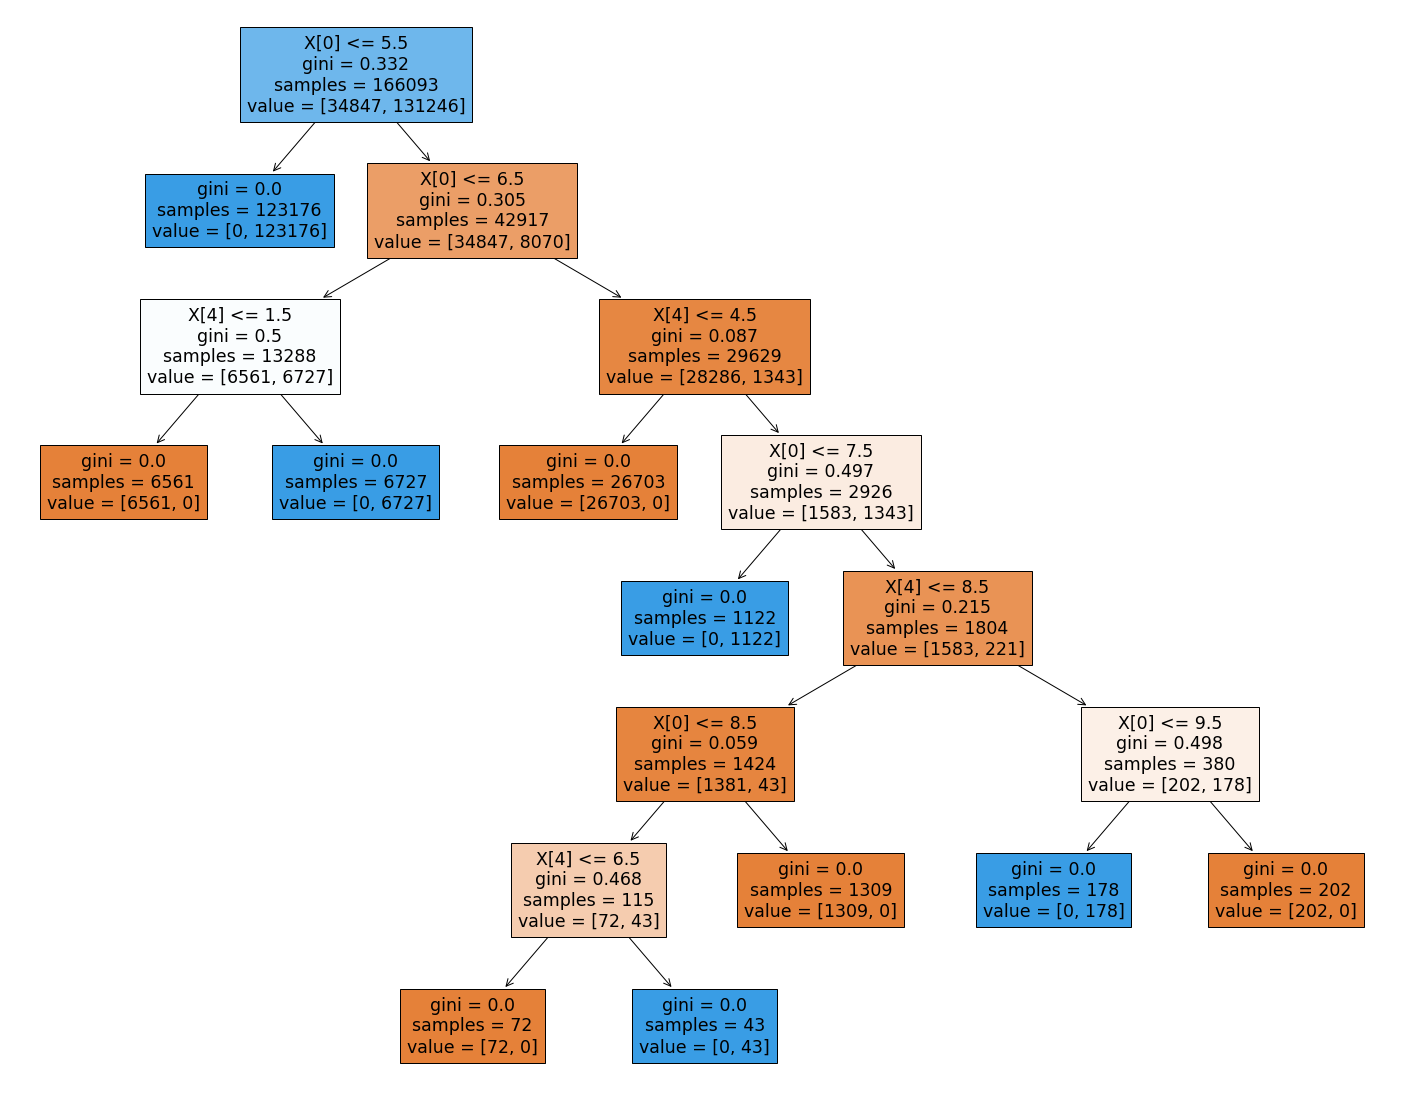

In [89]:
fig = plt.figure(figsize=(25,20))
plot_tree= tree.plot_tree(classifier,
                           
                   filled=True)

In [90]:
tree.export_graphviz(classifier, out_file="mytree.png",  
                     feature_names=feature_names ,  
                     class_names=True)

In [91]:
fig.savefig("decision_tree.png")

In [100]:
y_pred = classifier.predict(X_test)
print(y_pred)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[1 0 0 ... 1 1 1]
[[ 8705     0]
 [    0 32819]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8705
           1       1.00      1.00      1.00     32819

    accuracy                           1.00     41524
   macro avg       1.00      1.00      1.00     41524
weighted avg       1.00      1.00      1.00     41524

0.9986995472497833


In [49]:
df[3251:3260]

,Area,Alarm_Type,ehourCat,visibility,condition,Accident_Severity,Pothole_Severity,hasOversped,labels
3251,Kadugodi,HMW,PeakM,Low,Passing clouds,Medium,Medium,No,Low
3252,Kadugodi,HMW,PeakM,Low,Passing clouds,Medium,Medium,No,Low
3253,Kadugodi,HMW,PeakM,Low,Passing clouds,Medium,Medium,No,Low
3254,Bellanduru,Overspeed,PeakM,Low,Passing clouds,High,High,Yes,High
3255,Bellanduru,Overspeed,PeakM,Low,Passing clouds,High,High,Yes,High
3256,Bellanduru,HMW,PeakM,Low,Passing clouds,High,High,No,High
3257,Bellanduru,HMW,PeakM,Low,Passing clouds,High,High,No,High
3258,Bellanduru,HMW,PeakM,Low,Passing clouds,High,High,No,High
3259,Bellanduru,HMW,PeakM,Low,Passing clouds,High,High,No,High


In [50]:
import seaborn as sns

<AxesSubplot:xlabel='labels', ylabel='Accident_Severity'>

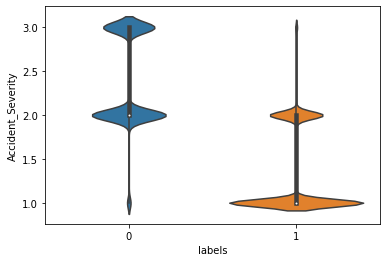

In [51]:
sns.violinplot(x = 'labels', y = 'Accident_Severity', data = b)

<AxesSubplot:xlabel='labels', ylabel='hasOversped'>

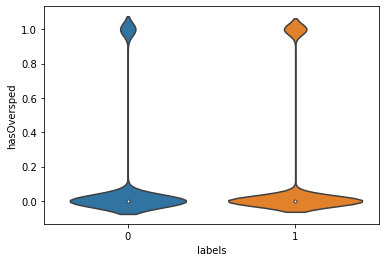

In [52]:
sns.violinplot(x = 'labels', y = 'hasOversped', data = b)

<AxesSubplot:xlabel='labels', ylabel='Alarm_Type'>

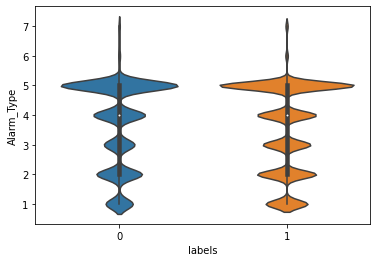

In [53]:
sns.violinplot(x = 'labels', y = 'Alarm_Type', data = b)

<AxesSubplot:xlabel='labels', ylabel='ehourCat'>

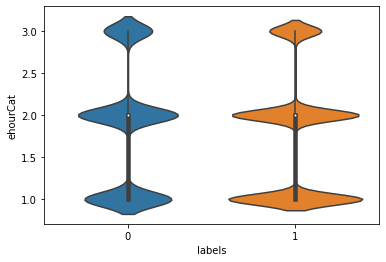

In [54]:
sns.violinplot(x = 'labels', y = 'ehourCat', data = b)

<AxesSubplot:xlabel='labels', ylabel='Pothole_Severity'>

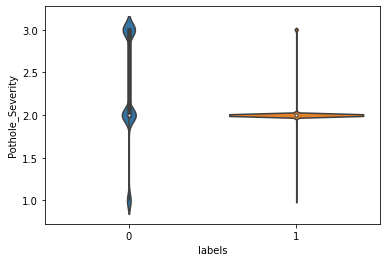

In [55]:
sns.violinplot(x = 'labels', y = 'Pothole_Severity', data = b)